In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

## 1A: Initializing the state space

In [11]:
class State:
    
    def __init__(self, x_position, y_position, heading):
        self.x_position = x_position
        self.y_position = y_position
        self.heading = heading
        
    def return_current_state(self):
        return self.x_position, self.y_position, self.heading

## 1B: Initializing the action space

In [12]:
class Action:
    
    def __init__(self, move, rotation):
        self.move = move
        self.rotation = rotation
        
    def return_action(self):
        return self.move, self.rotation

## 1C: Return the probabilty Psa(s') given pe, s, a, s'
## 1D: return a next state s' given error probability pe, s, a

### This is the Markov decision process

In [59]:
class MarkovDecisionProcess:
    
    # get the length and the width of the space that we are in
    def __init__(self, length, width):
        self.length = length
        self.width = width
    
    # check for bound violations
    def check_bounds(self, next_x, next_y, current_x, current_y):
        if (next_x < 0 or next_x >= self.width):
            next_x = current_x
        if (next_y < 0 or next_y >= self.length):
            next_y = current_y
        return next_x, next_y
    
    #define the directions
    left = {8,9,10}
    right = {2,3,4}
    up = {11,0,1}
    down = {5,6,7}
    
    # find out the next step --> returns next_x, next_y, next_heading
    def next_state_compiled(self, state, action):
        # get x, y and heading from state
        current_x = state.x_position
        current_y = state.y_position
        current_heading = state.heading
        
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the next step for the movements that have the prob of error
    def next_state_individualized(self, current_x, current_y, current_heading, move, rotation):
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the transition probabilities
    def transition_probabilities(self, prob_of_error, action, current_state, next_state):
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # if we do not move, current state should equal next state. 
        if move == 0:
            if current_state.return_current_state() == next_state.return_current_state():
                return 1
            else:
                return 0
        
        # in the case that we do move, need to account for the error probabilities
        
        if next_state.return_current_state() == self.next_state_compiled(current_state, action):
            return 1-(2*prob_of_error)
        else:
            current_x = current_state.x_position
            current_y = current_state.y_position
            current_heading = current_state.heading

            # need to check to return the prob of error
            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading-1)%12, move, rotation):
                return prob_of_error

            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading+1)%12, move, rotation):
                return prob_of_error
        
        return 0
    
    number_of_headings = 12
    
    # Part 1D
    def compute_next_state(self, prob_of_error, current_state, action):
        
        wrong_states = []
        # need to loop through all of the values of x, y and heading
        for i in range(self.length):
            for j in range(self.width):
                for k in range(self.number_of_headings):
                    # define the next state
                    next_state = State(i,j,k)
                    # find the transition probability between current state and the next state
                    prob_of_transition = self.transition_probabilities(prob_of_error, action, current_state, next_state)
                    # if the probability of transitioning does not equal 0, then only do we proceed. If 0, do not care
                    if prob_of_transition != 0:
                        # if our transition probabilty is the probability of error, it means that there was an error. Need to keep track of these next state values
                        if prob_of_transition == prob_of_error:
                            wrong_states.append(next_state)
                        else:
                            correct_next_state = next_state
        # if I choose a random number between 0 and 1 and my number is less than 2*prob_of_error, I move in the wrong direction. If not, I move in the correct direction.
        random_number_generated = np.random.uniform(0,1)
        if random_number_generated < 2*prob_of_error:
            try:
                random_index = random.randrange(len(wrong_states))
                return wrong_states[random_index]
            except ValueError:
                return correct_next_state
        else:
            return correct_next_state
    def reward(self, current_state):
        # define the lengh and the width
            length = width = 6

            # get the current x, y positions -- do not care about heading
            current_x, current_y, current_heading = current_state.return_current_state()

            # define the rewards
            if current_x == 3 and current_y == 4:
                if current_heading == 5 or current_heading == 6 or current_heading == 7:
                    reward = 1
                else:
                    reward = 0
            elif current_x == 0 or current_x == width-1:
                reward = -100
            elif current_y == 0 or current_y == length-1:
                reward = -100
            elif current_x == 2 or current_x == 4:
                if current_y == 2 or current_y == 3 or current_y == 4:
                    reward = -1
                else:
                    reward = 0
            else:
                reward = 0
            return reward

## Test question 1

In [36]:
r = MarkovDecisionProcess(6,6)
s = State(1,1,0)
f = Action(1,0)

print(r.compute_next_state(0.1, s, f).return_current_state())

(1, 2, 0)


## Question 2: Write a function that returns the reward R(s) given input s.

In [37]:
def reward_func(self, current_state):
    # define the lengh and the width
    length = width = 6

    # get the current x, y positions -- do not care about heading
    current_x, current_y, _ = current_state.return_current_state()

    # define the rewards
    if current_x == 3 and current_y == 4:
        reward = 1
    if current_x == 0 or current_x == width-1:
        reward = -100
    if current_y == 0 or current_y == height-1:
        reward = -100
    if current_x == 2 or current_x == 4:
        if current_y == 2 or current_y == 3 or current_y == 4:
            reward = -1
    else:
        reward = 0
    return reward

## Question 3a: Create and populate a matrix/array that stores the action a = pi0(s) prescribed by the initial policy pi0 when indexed by state s.

In [38]:
class Policy_Matrix:
    def __init__(self, given_policy=None):
        if given_policy == None:
            up = {11, 0, 1}
            right = {2, 3, 4}
            down = {5, 6, 7}
            left = {8, 9, 10}

            mat_up    = [[None for x in range(6)] for y in range(6)]
            mat_down  = [[None for x in range(6)] for y in range(6)]
            mat_left  = [[None for x in range(6)] for y in range(6)]
            mat_right = [[None for x in range(6)] for y in range(6)]

            rot = 0 # rotation (none-0,left--1,right-1)
            mov = 0 # move (none-0,back--1,forward-1)

            # populate up matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on right
                        rot = 1
                    elif (x>3): # goal on left
                        rot = -1
                    else:
                        rot = 0
                    # determine move
                    if (y<=4):
                        mov = 1
                    else:
                        mov = -1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_up[x][y] = mov, rot

            # populate down matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on left
                        rot = -1
                    elif (x>3): # goal on right
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if (y<=3):
                        mov = -1
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_down[x][y] = mov, rot

            # populate right matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on right
                        rot = 1
                    elif(y<4): # goal on left
                        rot = -1
                    else:
                        rot = 0
                    # determine move
                    if(x<4):
                        mov = 1
                    else:
                        mov = -1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_right[x][y] = mov, rot

            # populate left matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on left
                        rot = -1
                    elif(y<4): # goal on right
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if(x<3):
                        mov = -1
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_left[x][y] = mov, rot

            # matrix for each heading degree
            self.pol_mat = [[]]*12
            for heading in range(12):
                if heading in up:
                    self.pol_mat[heading] = mat_up
                elif heading in down:
                    self.pol_mat[heading] = mat_down
                elif heading in left:
                    self.pol_mat[heading] = mat_left
                else:
                    self.pol_mat[heading] = mat_right
        else:
            self.pol_mat = given_policy
            
    def policy_action(self, current_state):        
        pos_x = current_state.x_position
        pos_y = current_state.y_position
        heading = current_state.heading
        return self.pol_mat[heading][pos_x][pos_y]

if __name__ == "__main__":
    pi_0 = Policy_Matrix()
#     print(pi_0.pol_mat)

## Question 3b: Write a function to generate and plot a trajectory of a robot given policy matrix/array , initial state s0, and error probability pe.

In [49]:
def compute_trajectory(policy, current_state, prob_of_error):
    # initialize the trajectory
    full_trajectory = []
    full_headings = []
    # get the current x and y position
    current_x, current_y, current_heading = current_state.return_current_state()
    # append the current x and y to the trajectory as an array
    full_trajectory.append([current_x, current_y])
    full_headings.append(current_heading)
    i = 0
    # keep looping till we get to the goal
    while current_x != 3 or current_y != 4:
        move_from_policy, rotation_from_policy = policy.policy_action(current_state)
#         if move_from_policy == 0:
#             move = 0
#         if move_from_policy == 1:
#             move = -1
#         if move_from_policy == 2:
#             move = 1
#         if rotation_from_policy == 0:
#             rotation = 0
#         if rotation_from_policy == 1:
#             rotation = -1
#         if rotation_from_policy == 2:
#             rotation = 1
        action = Action(move_from_policy, rotation_from_policy)
        next_state = MarkovDecisionProcess(6,6).compute_next_state(prob_of_error, current_state, action)
        current_x, current_y, current_heading = next_state.return_current_state()
        full_trajectory.append([current_x, current_y])
        full_headings.append(current_heading)
        current_state = next_state
        i += 1
        if full_trajectory[i] == full_trajectory[i-1]:
            break
    return full_trajectory, full_headings

## Question 3c:

[[1, 4], [1, 3]]
[[1, 4], [1, 3], [1, 4]]
[[1, 4], [1, 3], [1, 4], [2, 4]]
[[1, 4], [1, 3], [1, 4], [2, 4], [3, 4]]


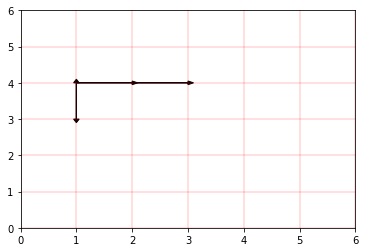

In [40]:
pi_0 = Policy_Matrix()
current_state = State(1,4,6)
full_trajectory, full_headings = compute_trajectory(pi_0, current_state, 0.25)
plt.xlim(0,6)
plt.ylim(0,6)
for i in range(len(full_trajectory)-1):
#     pass
    x,y = full_trajectory[i]
    x_one_up, y_one_up = full_trajectory[i+1]
    plt.arrow(x,y,x_one_up-x,y_one_up-y, head_width=0.1, head_length=0.1,fc='k', ec='k')
# plt.arrow(1, 4, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.grid(color='r', linestyle='-', linewidth=0.25)
plt.show()

## Question 3d:

In [41]:
# Helped function to calcluate all adjacent states. Need this for both policy and value iteration
def calc_adj_states(current_state):
    x = current_state.x_position
    y = current_state.y_position
    h = current_state.heading
    
    next_poss_h = [h,  (h+1) % 12, (h-1) % 12, (h+2) % 12, (h-2) % 12] # five possible headings
    next_poss_x = [x] # first possibility is not moving
    next_poss_y = [y] # first possibility is not moving
    
    # down, up, left, right
    if (x-1 >= 0):
        next_poss_x.append(x-1)
    if (x+1 < 6):
        next_poss_x.append(x+1)
    if (y-1 >= 0):
        next_poss_y.append(y-1)
    if (y+1 < 6):
        next_poss_y.append(y+1)        
    
    all_adj_states = []
    for x1 in next_poss_x:
        for y1 in next_poss_y:
            for h1 in next_poss_h:
                all_adj_states.append(State(x1,y1,h1))
    return all_adj_states

def policy_evaluation(initial_policy, discount_factor, prob_of_error):
    #start by defining some constants
    
    difference_between_iterations = -1
    
    init_V = np.zeros((12, 6, 6)) # initial value matrix
    
    # need to keep looping till we get to no difference between iterations
    while difference_between_iterations != 0:
        
        current_iteration = np.zeros((12, 6, 6))
        # need to loop through all possibilities
        for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    
                    for next_possible_state in poss_states:
                        # need to get the action, probability and reward
                        move_from_policy, rotation_from_policy = initial_policy.policy_action(current_state)
#                         if move_from_policy == 0:
#                             move = 0
#                         if move_from_policy == 1:
#                             move = -1
#                         if move_from_policy == 2:
#                             move = 1
#                         if rotation_from_policy == 0:
#                             rotation = 0
#                         if rotation_from_policy == 1:
#                             rotation = -1
#                         if rotation_from_policy == 2:
#                             rotation = 1
                        action = Action(move_from_policy, rotation_from_policy)
                        probability_of_move = MarkovDecisionProcess(6,6).transition_probabilities(prob_of_error, action, current_state, next_possible_state)
                        reward_for_move = MarkovDecisionProcess(6,6).reward(current_state)
                        
                        next_possible_x, next_possible_y, next_possible_heading = next_possible_state.return_current_state()
                        current_iteration[heading][x_pos][y_pos] += probability_of_move * (reward_for_move+(discount_factor*init_V[next_possible_heading][next_possible_x][next_possible_y]))
                        
        difference_between_iterations = np.sum(np.abs(current_iteration - init_V))
        init_V = current_iteration
    
    return current_iteration

## Question 3e: What is the value of the trajectory in 3(c)? Use lambda = 0.9

In [42]:
pi_0 = Policy_Matrix()
value = policy_evaluation(pi_0, 0.9, 0.25)
print(value)

[[[-384.63474901 -394.84873707 -398.78979131 -417.92068746 -447.47404262
   -417.92068746]
  [-185.87970245 -107.38974735 -131.77159671 -193.08049245 -278.42914782
   -293.08049245]
  [-178.81968209 -104.61933427 -140.40957514 -205.19083895 -288.0197623
   -295.19083895]
  [-119.40131313  -14.33354025   -8.31666789    0.            0.         -100.        ]
  [-171.83784783  -98.7333561  -135.87500252 -200.54278166 -282.38658809
   -290.54278166]
  [-374.76745661 -385.29368768 -388.25315856 -405.75059764 -435.93824578
   -405.75059764]]

 [[-362.03052379 -309.37493976 -319.93787367 -310.51189753 -367.63939586
   -362.96782829]
  [-238.49201797  -94.68443898 -114.52293932 -122.84142693 -242.29615001
   -273.96433189]
  [-232.81409282  -88.88145482 -115.36121209 -128.13880382 -255.05631706
   -263.92197038]
  [-180.44947442  -29.64489611  -24.21980514  -18.8768462     0.
   -192.83693686]
  [-261.37799404 -185.45432372 -229.50906758 -302.05775277 -304.3399899
   -326.23445344]
  [-439.69

In [43]:
value[6][1][4]

-68.502045724233867

## Question 3f: Write a function that returns a matrix/array A giving the optimal policy given a one-step lookahead on value

In [44]:
def look_ahead(value):
    action_space = [(-1, -1), (-1, 0), (-1, 1), (0, 0), (1, -1), (1, 0), (1, 1)]
    init_policy = [[[0 for x in range(6)]for y in range(6)]for heading in range(12)]
    prob_of_error = 0.25
    # same setup as the last quesiton, iterating through current state and finding next possible states
    for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    best_action = None
                    max_action_val = float('-inf')
                    for act in action_space:
                        action = Action(act[0], act[1]) # create action object for transition probability calculation
                        action_val = 0
                        for next_state in poss_states:
                            x_next, y_next, heading_next = next_state.return_current_state()
                            mdp = MarkovDecisionProcess(6,6)
                            action_val += mdp.transition_probabilities(prob_of_error, action, current_state, next_state) * value[heading_next][x_next][y_next]
                        if action_val > max_action_val:
                            max_action_val = action_val
                            best_action = action
                    init_policy[heading][x_pos][y_pos] = best_action.return_action()
    finalized_policy = Policy_Matrix(init_policy)
    return finalized_policy

## 3g: Combine 3f and 3d to returning optimal policy with optimal value V.

In [45]:
def policy_iteration(starting_policy, discount_factor):
        prev_value = policy_evaluation(starting_policy, discount_factor, 0.25)
        prev_policy_maximized = look_ahead(prev_value)
        conv = 0
        while conv != 1:
            current_value = policy_evaluation(prev_policy_maximized, discount_factor, 0.25)
            current_policy_maximized = look_ahead(current_value)
            if np.array_equal(current_value, prev_value):
                conv = 1
            prev_value = current_value
            prev_policy_maximized = current_policy_maximized
            print(prev_value)
        return current_value, current_policy_maximized

## 3h:recompute and plot the trajectory and value of the robot described in 3(c) under the optimal policy

In [60]:
pi_0 = Policy_Matrix()
current_state = State(1,4,6)
discount_factor = 0.9
maxed_value, maxed_policy = policy_iteration(pi_0, discount_factor)

[[[ -2.89698419e+02  -2.91965409e+02  -2.89698419e+02  -2.91965409e+02
    -3.02268600e+02  -3.14755423e+02]
  [ -1.00000000e+02   0.00000000e+00   0.00000000e+00  -2.73276522e-01
    -1.75911801e-01  -1.10276947e+02]
  [ -1.00000000e+02   0.00000000e+00  -1.00000000e+00  -1.90000000e+00
    -2.99647590e+00  -1.02262057e+02]
  [ -1.00000000e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
     0.00000000e+00  -1.00000000e+02]
  [ -1.00000000e+02   0.00000000e+00  -1.00000000e+00  -1.45790699e+01
    -2.10127437e+01  -1.22371494e+02]
  [ -2.93815600e+02  -2.93929894e+02  -2.93815600e+02  -2.93929894e+02
    -3.02445422e+02  -3.14484155e+02]]

 [[ -2.73987885e+02  -2.07849224e+02  -2.15877489e+02  -2.33000409e+02
    -2.38398345e+02  -2.98924779e+02]
  [ -1.48379295e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    -2.27497045e+01  -1.71472369e+02]
  [ -1.32436796e+02   0.00000000e+00  -1.00000000e+00  -2.10431599e+00
    -2.71753851e+00  -1.68094330e+02]
  [ -1.39438539e+

[[[ -2.86910571e+02  -2.89063955e+02  -2.86910571e+02  -2.86258581e+02
    -2.88765565e+02  -2.86258581e+02]
  [ -1.00000000e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
     8.93377916e-01  -9.91540569e+01]
  [ -9.96837175e+01   0.00000000e+00  -6.83717525e-01  -1.50630075e+00
    -1.31757858e+00  -9.97969980e+01]
  [ -1.00000000e+02   0.00000000e+00   2.46170028e+00   2.25214312e+00
     2.46170028e+00  -9.75012289e+01]
  [ -1.00000000e+02   0.00000000e+00  -1.00000000e+00  -1.28581974e+00
    -1.27440416e+00  -9.98593817e+01]
  [ -2.85848564e+02  -2.88192159e+02  -2.85848564e+02  -2.85956020e+02
    -2.88108395e+02  -2.85956020e+02]]

 [[ -2.69770798e+02  -2.06182269e+02  -2.11608717e+02  -2.25868681e+02
    -2.33534236e+02  -2.90749237e+02]
  [ -1.29433240e+02   0.00000000e+00   0.00000000e+00   7.83846747e-01
     0.00000000e+00  -1.64220353e+02]
  [ -1.30814400e+02   0.00000000e+00  -3.67435050e-01  -6.23091162e-01
     3.54271992e-01  -1.37491839e+02]
  [ -1.36952888e+

[[[ -2.85808065e+02  -2.88181792e+02  -2.85808065e+02  -2.85854609e+02
    -2.88252832e+02  -2.85854609e+02]
  [ -9.80227595e+01   1.83058177e+00   1.85088200e+00   2.04305874e+00
     1.85088200e+00  -9.79569413e+01]
  [ -9.87376834e+01   6.97559680e-01   2.62316586e-01  -4.89789463e-01
    -4.99326534e-01  -9.94897895e+01]
  [ -9.77669472e+01   2.32222927e+00   2.56119427e+00   2.55908323e+00
     2.56119427e+00  -9.74409168e+01]
  [ -9.91477440e+01   6.80510225e-02  -1.47743957e-01  -6.67059378e-01
    -8.01832932e-01  -9.96670594e+01]
  [ -2.85544800e+02  -2.87868783e+02  -2.85544800e+02  -2.85851253e+02
    -2.87909031e+02  -2.85851253e+02]]

 [[ -2.68644119e+02  -2.04876277e+02  -2.10835173e+02  -2.25297559e+02
    -2.33233417e+02  -2.90154898e+02]
  [ -1.28395920e+02   2.22281425e+00   1.97828515e+00   1.48236237e+00
     0.00000000e+00  -1.63913610e+02]
  [ -1.29865254e+02   1.34306654e+00   8.12355904e-01   4.93870000e-01
     6.09689421e-01  -1.36981610e+02]
  [ -1.35376796e+

[[[ -2.85807591e+02  -2.88180861e+02  -2.85807591e+02  -2.85852944e+02
    -2.88249560e+02  -2.85852944e+02]
  [ -9.80132808e+01   1.86692720e+00   1.98671919e+00   2.08739734e+00
     1.95440033e+00  -9.79126027e+01]
  [ -9.87376834e+01   6.97559680e-01   2.62316586e-01  -3.02440320e-01
    -4.57172977e-01  -9.94803049e+01]
  [ -9.77669472e+01   2.32222927e+00   2.56119427e+00   2.55908323e+00
     2.56119427e+00  -9.74409168e+01]
  [ -9.91463104e+01   7.43715429e-02  -1.46310350e-01  -6.66922623e-01
    -8.01513648e-01  -9.96669226e+01]
  [ -2.85544798e+02  -2.87868781e+02  -2.85544798e+02  -2.85851252e+02
    -2.87909029e+02  -2.85851252e+02]]

 [[ -2.68643562e+02  -2.04875733e+02  -2.10833535e+02  -2.25293734e+02
    -2.33231778e+02  -2.90151068e+02]
  [ -1.28379565e+02   2.22570528e+00   1.99113416e+00   1.53946911e+00
     0.00000000e+00  -1.63855642e+02]
  [ -1.29865253e+02   1.34306654e+00   8.12355904e-01   4.93870000e-01
     6.09689422e-01  -1.36949598e+02]
  [ -1.35376794e+

In [61]:
maxed_policy.pol_mat[5][1][1]

(0, 0)

In [62]:
full_trajectory, full_headings = compute_trajectory(maxed_policy, current_state, 0.25)

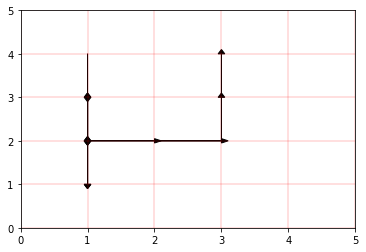

In [63]:
plt.xlim(0,5)
plt.ylim(0,5)
for i in range(len(full_trajectory)-1):
#     pass
    x,y = full_trajectory[i]
    x_one_up, y_one_up = full_trajectory[i+1]
    plt.arrow(x,y,x_one_up-x,y_one_up-y, head_width=0.1, head_length=0.1,fc='k', ec='k')
# plt.arrow(1, 4, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.grid(color='r', linestyle='-', linewidth=0.25)
plt.show()

In [64]:
print(full_headings[-1])

7


In [65]:
print(full_trajectory)

[[1, 4], [1, 3], [1, 2], [1, 3], [1, 2], [1, 1], [1, 2], [1, 3], [1, 2], [1, 1], [1, 2], [2, 2], [3, 2], [3, 3], [3, 4]]


## Question 4a:

In [66]:
action_space = [(-1, -1), (-1, 0), (-1, 1), (0, 0), (1, -1), (1, 0), (1, 1)]


def value_iteration(discount):
    prev_V = np.zeros((12, 6, 6)) # initial value matrix
    new_pol_mat = [[[None for l in range(6)] for w in range(6)] for h in range(12)] # new policy matrix
    err_p = 0.25 # error probability
    conv = 0 # convergence boolean
    
    while (conv != 1):
        new_V = np.zeros((12, 6, 6)) # new value matrix
        mdp = MarkovDecisionProcess(6,6)
        for x_pos in range(6):
            for y_pos in range(6):
                for heading in range(12):
                    current_state = State(x_pos, y_pos, heading)
                    poss_states = calc_adj_states(current_state)
                    best_action = None
#                     print(heading, x_pos, y_pos)
                    max_action_val = float('-inf')
                    for act in action_space:
                        action = Action(act[0], act[1]) # create action object for transition probability calculation
                        action_val = 0
                        for next_state in poss_states:
                            x_, y_, h_ = next_state.return_current_state()
                            action_val += mdp.transition_probabilities(err_p, action, current_state, next_state) * (mdp.reward(current_state) + discount*prev_V[h_][x_][y_])
                        if (action_val > max_action_val):
                            max_action_val = action_val
                            best_action = action
                    # update policy matrix and new value matrix
                    new_pol_mat[heading][x_pos][y_pos] = best_action.return_action()
                    new_V[heading][x_pos][y_pos] = max_action_val
        
        # check if convergence occurs
#         print(np.sum(np.abs(new_V - prev_V)))
        if(np.array_equal(new_V, prev_V)):
            conv = 1
        # if not, update value matrix
#         print('didnt converge')
        prev_V = new_V
    # create final policy
    new_pol = Policy_Matrix(new_pol_mat)
    return new_pol, new_V

In [67]:
# testing value iteration function
discount = 0.9
opt_pol, opt_val = value_iteration(discount)


In [68]:
print(opt_pol.pol_mat)
print(opt_val)

[[[(1, 1), (1, 1), (-1, 1), (1, -1), (-1, -1), (-1, -1)], [(1, 1), (1, 1), (-1, 1), (1, -1), (-1, -1), (-1, -1)], [(1, 1), (1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)], [(1, 1), (1, 0), (1, -1), (1, -1), (-1, -1), (-1, -1)], [(1, -1), (1, 1), (-1, -1), (1, 1), (-1, 1), (-1, 1)], [(1, -1), (1, -1), (-1, -1), (1, 1), (-1, 1), (-1, 1)]], [[(1, 1), (1, 1), (1, 1), (1, 1), (-1, 1), (-1, 1)], [(1, -1), (1, 1), (1, 1), (1, -1), (0, 0), (-1, -1)], [(1, -1), (1, 1), (-1, 1), (1, 1), (-1, 1), (-1, -1)], [(1, -1), (1, 1), (1, 1), (1, 1), (-1, 1), (-1, -1)], [(1, 1), (0, 0), (-1, -1), (-1, 1), (-1, 1), (-1, -1)], [(1, 1), (1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]], [[(1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (1, -1)], [(1, -1), (1, 1), (1, 1), (1, 1), (0, 0), (1, -1)], [(1, -1), (1, 1), (1, 1), (1, 1), (-1, 1), (-1, -1)], [(1, -1), (1, 1), (1, 1), (1, 1), (-1, 1), (-1, -1)], [(-1, -1), (0, 0), (-1, 1), (-1, 1), (-1, 1), (-1, -1)], [(-1, -1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, -1)]], [[(1, -1

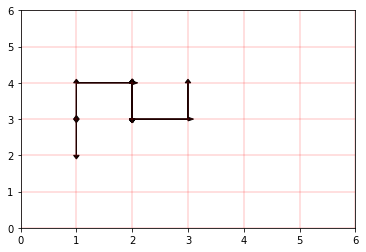

In [69]:
current_state = State(1,4,6)
discount_factor = 0.9
full_trajectory, full_headings = compute_trajectory(opt_pol, current_state, 0.25)
plt.xlim(0,6)
plt.ylim(0,6)
for i in range(len(full_trajectory)-1):
#     pass
    x,y = full_trajectory[i]
    x_one_up, y_one_up = full_trajectory[i+1]
    plt.arrow(x,y,x_one_up-x,y_one_up-y, head_width=0.1, head_length=0.1,fc='k', ec='k')
# plt.arrow(1, 4, 0, -1, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.grid(color='r', linestyle='-', linewidth=0.25)
plt.show()

In [70]:
print(full_headings[-1])

5


## Question 5b: Assume the reward of +1 only applies when the robot is pointing down, e.g. h 5; 6; 7 in the goal square; the reward is 0 otherwise. Recompute trajectories and values given initial conditions from 3(c) with pe = 25%.